This is part 4 of a course called Full Stack Graph Machine Learning by <a href="https://linkedin.com/in/russelljurney">Russell Jurney</a>. For team training inquiries contact <a href="mailto:rjurney@graphlet.ai">rjurney@graphlet.ai</a>.

In [1]:
import gzip
import os
import pickle
import tarfile
from pprint import pprint
from typing import Dict, List, Optional

import graphistry
import dgl
# import igraph as ig
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
# import optuna
import pandas as pd
import seaborn as sns
import torch
from dgl.data import DGLDataset
from dgl.data.utils import download as dgl_download
from dgl.data.utils import load_graphs, save_graphs
from dgl.sampling import global_uniform_negative_sampling
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split

from graphml_class.clean import clean_graph
from graphml_class.palette import CATEGORICAL_PALETTE

In [2]:
SEED = 31337

# Graph Machine Learning by Hand

The old-school method of machine learning that was common practice before graph embeddings and Graph Neural Networks was to hand engineer features of the nodes of a network by querying the network with `networkx` or a graph database like Neo4j using Cypher or Gremlin and to assign the results of those queries to nodes.

What are some common features when hand engineering node features in graph machine learning tasks?

## Hand Engineered Features in Graph ML

* Scalable Centralities: Degree [in, out, total], Eigenvector, PageRank [a form of eigenvector centrality], Katz
* Less Scalable Centralities: Closeness, Betweenness

You can compute these methods on single edges or on multiple edges as a way of projecting a _higher-order_ network, a network composed of more complex semantics built from the base network. Graph ML worked this way until around 2015, when graph embeddings changed everything :)

Check out [networkx.algorithms.centrality](https://networkx.org/documentation/stable/reference/algorithms/centrality.html) and find some that fit different aspects of networks you'd like to include in a classifier.

## Loading our Citation Graph

In Part 1 on knowledge graph construction, we saved our graph in GEXF format. Let's load it using the same procedure we performed in Part 2. I'm going to abbreviate the comments here, look at Part 2 for more details on what I am doing.

In [3]:
G: nx.DiGraph = nx.read_gexf(path="data/physics_labeled.gexf.gz")

In [4]:
G.number_of_nodes(), G.number_of_edges()

(27770, 352807)

In [5]:
with open("data/citation/file_to_net.pkl", "rb") as f:
    file_to_net = pickle.load(f)

# Everything ok? Yes!
list(file_to_net.items())[0:10]

[(1001, 0),
 (9304045, 1),
 (9308122, 2),
 (9309097, 3),
 (9311042, 4),
 (9401139, 5),
 (9404151, 6),
 (9407087, 7),
 (9408099, 8),
 (9501030, 9)]

In [6]:
with open("data/citation/net_to_file.pkl", "rb") as f:
    net_to_file = pickle.load(f)

# Everything ok here too? Yes!
list(net_to_file.items())[0:10]

[(0, 1001),
 (1, 9304045),
 (2, 9308122),
 (3, 9309097),
 (4, 9311042),
 (5, 9401139),
 (6, 9404151),
 (7, 9407087),
 (8, 9408099),
 (9, 9501030)]

In [7]:
def convert_ids_to_int(G):
    # Create a new directed graph
    G_int = nx.DiGraph()
    
    # Create a mapping from string IDs to integer IDs
    id_mapping = {str_id: int(str_id) for str_id in G.nodes()}
    
    # Copy nodes and attributes, converting IDs to integers
    for str_id, data in G.nodes(data=True):
        int_id = id_mapping[str_id]
        G_int.add_node(int_id, **data)
    
    # Copy edges and attributes, converting IDs to integers
    for str_id1, str_id2, data in G.edges(data=True):
        int_id1, int_id2 = id_mapping[str_id1], id_mapping[str_id2]
        G_int.add_edge(int_id1, int_id2, **data)
    
    return G_int

# Convert G to use integer IDs
G_int = convert_ids_to_int(G)

In [8]:
G_int.number_of_nodes(), G_int.number_of_edges()

(27770, 352807)

In [9]:
# Let's test or integer index now... we pickled it instead of JSONized it so it would retain its integer keys and values!
test_id = file_to_net[9711194]
G_int.nodes[test_id]

{'file_id': 9711194,
 'sequential_id': 5886,
 'Paper': 'hep-th/9711194',
 'Date': 'Wed, 26 Nov 1997 20:26:20 GMT',
 'Title': 'On Integrable Structure behind the Generalized WDVV Equations',
 'Comments': 'LaTeX, 6pp',
 'Report-no': 'ITEP/TH-67/97',
 'Journal-ref': 'Phys.Lett. B427 (1998) 93-96',
 'Abstract': 'In the theory of quantum cohomologies the WDVV equations imply integrability of the system $(I\\partial_\\mu - zC_\\mu)\\psi = 0$. However, in generic situation -- of which an example is provided by the Seiberg-Witten theory -- there is no distinguished direction (like $t^0$) in the moduli space, and such equations for $\\psi$ appear inconsistent. Instead they are substituted by $(C_\\mu\\partial_\\nu - C_\\nu\\partial_\\mu)\\psi^{(\\mu)} \\sim (F_\\mu\\partial_\\nu - F_\\nu\\partial_\\mu)\\psi^{(\\mu)} = 0$, where matrices $(F_\\mu)_{\\alpha\\beta} = \\partial_\\alpha \\partial_\\beta \\partial_\\mu F$.',
 'Journal-ref-DBSCAN': 2,
 'Journal-ref-Label': 'Phys.Lett.',
 'label': '588

### `G_int` --> `G`

Now we can assign our new integer graph back to `G` and use it below :)

In [10]:
G = G_int

## Feature Engineering for Node Classification

We are going to load our citation graph and then combine a simple encoding of the text features with manually computed features to perform node classification. We will see how our network metrics describing topology affect performance. Try not to always jump to using a network embedding, this is a useful exercise as a baseline :)

Our job is to prepare a network features vector `features` that we can append to our other features before we train a classifier to perform link prediction.

### Historical Review

Remember these slides? Think on them again :) We are going to implement a couple of these to drive our first Journal classifier :) This slide shows numerous methods used in link prediction.

<center><img src="images/Feature-Engineering-for-Link-Prediction.jpg" width="1000px" /></center>
<center><i>Feature engineering for link predicton can be complicated due to the need to compute them for pairs of nodes.</i></center>

<br />

<center><img src="images/JanusGraph-Titan-Feature-Engineering-in-2014.png" width="1000px" /></center>
<center><i>Feature engineering circa 2014 on a business graph representing relationships between companies in a property graph using <a href="https://titan.thinkaurelius.com/">Titan</a> via <a href="https://tinkerpop.apache.org/gremlin.html">Tinkerpop / Gremlin</a>. Titan became <a href="https://janusgraph.org/">JanusGraph</a>.</i></center>

<br />

### Store Features by Column in `features`

We will compute features for each node or pairs of nodes and then store them in the `features` `np.ndarray` by appending one column at a time. One row is a node. This is described in [NumPy: How to add an extra column to a NumPy array](https://www.w3resource.com/python-exercises/numpy/python-numpy-exercise-86.php) as looking like:

<center><img src="images/append-column-to-matrix.png" width="500px" /></center>
<center>Image Source: <a href="https://www.w3resource.com/python-exercises/numpy/python-numpy-exercise-86.php">w3resource: NumPy: How to add an extra column to a NumPy array</a></center>

#### Re-Running Feature Appends Will Make Duplicate Feature Columns

Warning: If you run the cells below that do `np.append(features, my_feat_ary, axis=1)` more than once... you will get a duplicate features column.

In [11]:
# I had to look this up, so here you are :)
import numpy as np
x = np.array([[10,20,30], [40,50,60]])
y = np.array([[100], [200]])
x, y, np.append(x, y, axis=1)

(array([[10, 20, 30],
        [40, 50, 60]]),
 array([[100],
        [200]]),
 array([[ 10,  20,  30, 100],
        [ 40,  50,  60, 200]]))

### Initialize `features` `nd.array`

You can re-run this to recalculate the features from scratch.

In [12]:
# Create an inner list for each node ID
inner_lists = [[] for x in range(G.number_of_nodes())]

# The shape is 27,770 nodes long with zero feature columns
features = np.array(inner_lists)
features, features.shape

(array([], shape=(27770, 0), dtype=float64), (27770, 0))

### `networkx` Centrality Metrics

For our first features, we will use `networkx` to compute some centrality metrics. I'm going to limit our calculations to two centralities you can use in practice on networks of most any size:

* Degree Centrality (in degree, out degree, degree [both]) - this is simple and shows how well connected a node is
* Eigenvector Centrality - measures the influence of a node in a network, where a node is considered influential if it is connected to other influential nodes.

Check out this list of [networkx.centrality](https://networkx.org/documentation/stable/reference/algorithms/centrality.html) metrics for feature ideas.

#### Display Metrics using `pd.Series`

If you want to see a metric computer by `nx.my_function()` you can wrap the `Dict` it returns [which will ALL print in a notebok] in a `pd.Series` and it will use the node ID as the index and display the feature. It is a good idea to lay eyes on things you compute - when possible - as often something goes wrong on a first attempt :)

#### Degree Centrality

Degree centrality is a **local centrality** metric. It measure influence in the nearby network.

NetworkX measures degree centrality as a relative value for all nodes in a network. This can complicate inference but keeps values within an interpretable range.

In [13]:
degree = nx.degree_centrality(G)

# See - takes just 11 lines. The Dict printed over 27K rows on my screen. Try it!
pd.Series(degree)

0        0.003349
1        0.000612
2        0.004393
3        0.005186
4        0.002053
           ...   
27765    0.000036
27766    0.000216
27767    0.000216
27768    0.000036
27769    0.000288
Length: 27770, dtype: float64

In [14]:
in_degree = nx.in_degree_centrality(G)
pd.Series(in_degree)

0        0.000360
1        0.000576
2        0.004141
3        0.005042
4        0.001981
           ...   
27765    0.000036
27766    0.000000
27767    0.000000
27768    0.000000
27769    0.000000
Length: 27770, dtype: float64

In [15]:
out_degree = nx.out_degree_centrality(G)
pd.Series(out_degree)

0        0.002989
1        0.000036
2        0.000252
3        0.000144
4        0.000072
           ...   
27765    0.000000
27766    0.000216
27767    0.000216
27768    0.000036
27769    0.000288
Length: 27770, dtype: float64

#### Eigenvector Centrality

Eigenvector centrality is a **global centrality** metric. It measures influence within the entire network. _We always want a local and global centrality metric in our feature set_. To understand eigenvectors, check out this amazing simulation: [Eigenvectors and Eigenvalues](https://setosa.io/ev/eigenvectors-and-eigenvalues/)

In [16]:
# Eigenvector centrality is problematic in disconnected graphs, so take the largest component...
components = nx.connected_components(G.to_undirected())
largest_component = max(components, key=len)
G_big_component = G.subgraph(largest_component).copy()

print(f"Largest comonent size: {len(G_big_component):,}")

Largest comonent size: 27,400


In [17]:
# Visualize the eigenvectors... see 
eigenvector = nx.eigenvector_centrality_numpy(G_big_component.to_undirected())
pd.Series(eigenvector)

0        1.349286e-02
1        3.755065e-04
2        8.061580e-03
3        8.825151e-03
4        4.601559e-03
             ...     
27765    6.954306e-09
27766    2.261535e-06
27767    3.047158e-03
27768    1.374439e-05
27769    2.980450e-04
Length: 27400, dtype: float64

In [18]:
# ... and make it undirected, to ensure it is connected
eigenvectors = nx.eigenvector_centrality_numpy(
    G_big_component.to_undirected()
)

for node, score in eigenvectors.items():
    G_big_component.nodes[node]["eigenvector"] = score
    G_big_component.nodes[node]["eigenvector_log10"] = np.log10(score + 0.000001)  # can't be zero for log

In [19]:
# Initialize eigenvector_centrality property as 0 for all nodes
nx.set_node_attributes(G, 0.0, "eigenvector")
nx.set_node_attributes(G, 0.0, "eigenvector_log10")

# Assign the eigenvector centrality values from subgraph to original graph
nx.set_node_attributes(G, {node: eigenvectors[node] for node in G_big_component}, "eigenvector")
nx.set_node_attributes(G, {node: np.log10(G.nodes[node]['eigenvector'] + 1e-10) for node in G.nodes()}, "eigenvector_log10")

In [20]:
eigenvector_dict = nx.get_node_attributes(G, 'eigenvector')

In [21]:
# Get an array for our features array
eigenvector_array = np.array([G.nodes[node]["eigenvector"] for node in G.nodes()])
pd.Series(eigenvector_array)

0        1.349286e-02
1        3.755065e-04
2        8.061580e-03
3        8.825151e-03
4        4.601559e-03
             ...     
27765    6.954306e-09
27766    2.261535e-06
27767    3.047158e-03
27768    1.374439e-05
27769    2.980450e-04
Length: 27770, dtype: float64

### Add to `features` `np.array`

That gives us four features so far that indicate a node's prominence in the network. Let's combine them to produce a four feature long feature vector.

In [22]:
np.array(list(degree.values())[0:10]), np.array(list(degree.values())[0:10]).reshape(-1, 1)

(array([0.00334906, 0.00061219, 0.00439339, 0.00518564, 0.00205265,
        0.01660125, 0.0028449 , 0.04710288, 0.03647953, 0.00550974]),
 array([[0.00334906],
        [0.00061219],
        [0.00439339],
        [0.00518564],
        [0.00205265],
        [0.01660125],
        [0.0028449 ],
        [0.04710288],
        [0.03647953],
        [0.00550974]]))

In [23]:
# Prepare and append the degree features for addition to `features`
for d in [degree, in_degree, out_degree, eigenvector_dict]:
    d_ary = np.array(list(d.values())).reshape(-1, 1)
    features = np.append(features, d_ary, axis=1)

features, features.shape

(array([[3.34905830e-03, 3.60113796e-04, 2.98894451e-03, 1.34928555e-02],
        [6.12193453e-04, 5.76182074e-04, 3.60113796e-05, 3.75506540e-04],
        [4.39338831e-03, 4.14130865e-03, 2.52079657e-04, 8.06157958e-03],
        ...,
        [2.16068278e-04, 0.00000000e+00, 2.16068278e-04, 3.04715788e-03],
        [3.60113796e-05, 0.00000000e+00, 3.60113796e-05, 1.37443864e-05],
        [2.88091037e-04, 0.00000000e+00, 2.88091037e-04, 2.98045032e-04]]),
 (27770, 4))

### Community Detection with Louvain Modularity

What about other kinds of features? One important category is the local group a node belongs to after performing an operation called 

One thing we didn't cover in Part 2 - Network Science, was community detection. What community a node belongs to is an important feature. We're going to cluster our network into communities and visualize them in Graphistry. Then we're going to add the cluster IDs as features in our `features` `np.array`.

While there are many network clustering algorithms, the most common method of community detection is [Louvain Modularity](https://en.wikipedia.org/wiki/Louvain_method). We're going to use [nx.community.louvain_communities](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html#networkx.algorithms.community.louvain.louvain_communities) because it is efficient enough to work on networks up to moderate size using one computer. You can usually find a Louvain Modularity implementation for whatever platform you use to process even large networks - big data.

> The method is a greedy optimization method that appears to run in time `O(n * log(n))`.
>
> ...
> 
> In the Louvain Method of community detection, first small communities are found by optimizing modularity locally on all nodes, then each small community is grouped into one node and the first step is repeated.

-- Wikipedia, [Louvain method](https://en.wikipedia.org/wiki/Louvain_method)

In [24]:
clusters = nx.community.louvain_communities(G, seed=SEED)
len(clusters)

173

#### Evaluating Modularity

I am curious how many clusters there are... lets plot their size in Seaborn using log scale. You can see there is a power law distribtion in cluster size.

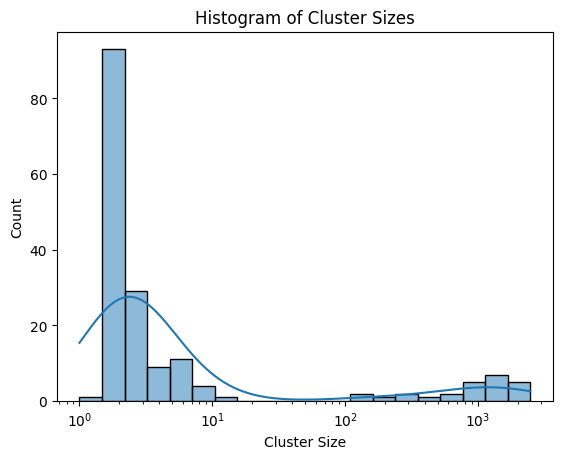

In [25]:
# Get connected components and their sizes
cluster_size = [len(c) for c in clusters]

# Use seaborn to create the histogram
sns.histplot(cluster_size, kde=True, bins=20, log_scale=True)
plt.title("Histogram of Cluster Sizes")
plt.xlabel("Cluster Size")
plt.ylabel("Count")
plt.show()

In [26]:
pprint(sorted(cluster_size, reverse=True)[0:50], indent=4, compact=True)

[   2481, 2144, 1779, 1731, 1727, 1596, 1594, 1551, 1447, 1412, 1332, 1255,
    1108, 919, 844, 835, 817, 674, 540, 495, 316, 314, 170, 157, 113, 11, 10,
    10, 8, 8, 7, 7, 6, 6, 6, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4]


### ChatGPT and Me

I needed to do consult a reference to interpret what this might mean for a citation graph... I knew it had a power law distribution with a long tail. I fed the following prompt to ChatGPT-4 Browser:

#### **CHATGPT PROMPT**

I have a citation graph of physics papers from arXiv, the high energy physics citation network from Stanford SNAP. I used NetworkX to compute Louvain Modularity and measured cluster sizes. Then I plotted them in seaborn on a log scale.

The first 50 cluster sizes, sorted in descending order are:

```
[   2481, 2144, 1779, 1731, 1727, 1596, 1594, 1551, 1447, 1412, 1332, 1255,
    1108, 919, 844, 835, 817, 674, 540, 495, 316, 314, 170, 157, 113, 11, 10,
    10, 8, 8, 7, 7, 6, 6, 6, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4]
```

Please interpret this histogram of cluster sizes and tell me what it means for a citation graph.

#### Comment

The output checks out... ChatGPT-4 can interpret a histogram in a specific domain fairly well. Check it out. I'm trying to demonstrate how to incorporate AI into your workflows... I did ask it to rewrite this in fewer words, but I'm printing the entire output below.

#### **CHATGPT RESPONSE**

The cluster sizes you've provided, derived from applying the Louvain Modularity algorithm on a citation graph of physics papers, represent the sizes of communities of papers that cite each other. The sizes are listed in descending order, indicating a few large clusters followed by many smaller ones. This pattern is typical in real-world networks and is often referred to as a scale-free or heavy-tailed distribution. Here are a few interpretations and insights based on this distribution:

* Community Structure - There are a few large communities of papers (e.g., the largest has 1909 papers) which likely represent major topics or fields within high energy physics. These large clusters suggest that there are common themes that have garnered significant attention and citation in the community.
* Long Tail - As we move down the list, the cluster sizes decrease, forming a long tail of smaller communities. This indicates a wide variety of specialized or niche topics within the field that have smaller groups of papers citing each other.
* Power-Law Distribution - The distribution of cluster sizes resembles a power-law distribution, which is common in many natural and social phenomena. In a power-law distribution, a few items (in this case, topics or fields) are exceptionally common, but the vast majority are rare.
* Interdisciplinary or Emerging Areas - The smaller clusters may represent interdisciplinary or emerging areas of research that have not yet amassed a large number of citations.
* Potential for Further Exploration - Understanding the thematic content of the large clusters could provide insights into the major areas of focus in high energy physics, while exploring the smaller clusters might reveal emerging or under-explored areas of research.
* Rich-Get-Richer Phenomenon - The distribution may also reflect a "rich-get-richer" phenomenon where well-cited papers continue to accumulate more citations over time, reinforcing the prominence of certain topics.
* Validation of Louvain Modularity - The distribution of cluster sizes could also serve as a validation of the Louvain Modularity algorithm's effectiveness in detecting community structure within the citation network.

### Featurizing Communities

To featurize our communities, we need to assign numeric values to the clusters and append a column for cluster ID to `features`. Note, we could alternatively [one-hot-encode](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) the features to give them one feature column per cluster. This would make the features sparse, which means lesss signal - something neural networks don't like but that another algorithm might not mind. We could use the [hashing trick](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.FeatureHasher.html) - a method of feature engineering somewhere in between one-hot-encoding and neural embeddings. We are instead going to _label encode_ them with [sklearn.preprocessing.LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

In [27]:
# for cluster in clusters:
pprint(clusters[0:3], indent=4, compact=True)

[   {   1191, 1214, 1313, 1314, 1358, 1389, 1461, 1753, 1793, 1799, 1976, 1978,
        2074, 2636, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705,
        2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717,
        2718, 2719, 2720, 2724, 2725, 2726, 2727, 2818, 2821, 2822, 2823, 2824,
        3025, 3026, 3217, 3218, 3219, 3220, 3515, 3758, 3889, 3890, 3891, 3892,
        3893, 3894, 3897, 3898, 3899, 3900, 3901, 3902, 3903, 3904, 3905, 3906,
        3907, 3908, 3909, 3910, 3911, 3912, 3914, 3915, 3916, 3917, 3918, 3919,
        3920, 3923, 3929, 4331, 4354, 4355, 4533, 4762, 4763, 4861, 4862, 4863,
        4864, 4865, 4866, 4867, 4868, 4869, 4870, 4871, 4872, 4873, 4874, 4875,
        4876, 4877, 4878, 4879, 4880, 4881, 4882, 4883, 4884, 4885, 4886, 4887,
        4888, 4889, 4890, 4891, 4892, 4893, 4894, 4895, 4896, 4897, 4899, 4900,
        4902, 4903, 4904, 4905, 4906, 4907, 4908, 4909, 4910, 4911, 4912, 4913,
        4914, 4915, 4916, 4917, 5002, 50

In [28]:
# Iterate through clusters, assigning cluster IDs, then map them to node IDs
node_clusters: Dict[int, int] = {}
for cluster_id, cluster in zip(range(len(clusters)), clusters):
    for node_id in cluster:
        node_clusters[node_id] = cluster_id

node_series = pd.Series(node_clusters).sort_index()
node_series

0          3
1          3
2          3
3          3
4          3
        ... 
27765     65
27766      6
27767    157
27768     15
27769     31
Length: 27770, dtype: int64

### Append Clusters to `features`

Note, the clusters number from approximately 1-1,500. This dwarfs the previously computed, normalized centrality scores. We will be using scikit-learn's [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to address this.

Now we've got 5 topological features. We are going to add one more and then do a simple feature extraction of our Titles and Abstracts that might normally go with a first pass at a node classifier.

In [29]:
# Prepare and append the degree features for addition to `features`
cluster_ary = np.array(node_series).reshape(-1, 1)
features.shape, cluster_ary.shape

((27770, 4), (27770, 1))

In [30]:
features = np.append(features, d_ary, axis=1)
features, features.shape

(array([[3.34905830e-03, 3.60113796e-04, 2.98894451e-03, 1.34928555e-02,
         1.34928555e-02],
        [6.12193453e-04, 5.76182074e-04, 3.60113796e-05, 3.75506540e-04,
         3.75506540e-04],
        [4.39338831e-03, 4.14130865e-03, 2.52079657e-04, 8.06157958e-03,
         8.06157958e-03],
        ...,
        [2.16068278e-04, 0.00000000e+00, 2.16068278e-04, 3.04715788e-03,
         3.04715788e-03],
        [3.60113796e-05, 0.00000000e+00, 3.60113796e-05, 1.37443864e-05,
         1.37443864e-05],
        [2.88091037e-04, 0.00000000e+00, 2.88091037e-04, 2.98045032e-04,
         2.98045032e-04]]),
 (27770, 5))

## Role Discovery via RolX and ReFeX

RolX role discovery is one of my favorite algorithms for networks :) You may recall from the slides how I used it to build a visually appealing, intrepretable map of the big data market. We're going to compute RolX roles to use as feature for ML tasks.

### RolX

You can learn more about RolX in the paper [RolX: Structural Role Extraction & Mining in Large Graphs](https://web.eecs.umich.edu/~dkoutra/papers/12-kdd-recursiverole.pdf).

<center><img src="images/RolX-Roles-vs-Communities.png" width="550px" /></center>
<center><i>You can see the difference between structural roles and communities. A related concept called _network motifs_ or structural patterns in networks can determine the nodes roles play in their neighborhoods.</i></center>

<br /><br />

<center><img src="images/Graph-ML-Class-Slide-for-Rolx-Roles-for-Mapping-Big-Data.png" width="1000px" /></center>
<center><i>An example of RolX in action to filter nodes with roles I didn't care about from a visualization to tell the story of interest.</i></center>

### ReFeX via `graphrole`

ReFex is a role discovery algorithm similar to RolX. It was defined in [It’s Who You Know: Graph Mining Using Recursive Structural Features](https://www.andrew.cmu.edu/user/lakoglu/pubs/ReFeX.pdf).

GraphRole draws from Rolx and ReFeX to do role discovery. Note that the `graphrole` implementation of RolX is a little slow... even on this network. The reality is that for large networks, you need the support of a data engineer to implement algorithms. It isn't feasible to teach a lot of large network computing skills in a five day, four hour course. RolX itself was designed to support large networks, and there are other implementations available.

Therefore I have pickled the results and made them available for you to load. **Feel free to uncomment the next block of code out and run it if you like, otherwise the RolX features are computed and stored in Github.** They are loaded below.

In [31]:
from graphrole import RecursiveFeatureExtractor, RoleExtractor


# Extract features
feature_extractor = RecursiveFeatureExtractor(G)
rolx_features = feature_extractor.extract_features()

# Calculate roles
role_extractor = RoleExtractor(n_roles=None)
role_extractor.extract_role_factors(rolx_features)

# Can also use role percentages
role_extractor.role_percentage

,role_0,role_1,role_2,role_3,role_4,role_5,role_6
0,0.062544,0.449980,0.092409,0.222163,0.000590,0.171724,0.000590
1,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
2,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
3,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
4,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
...,...,...,...,...,...,...,...
27765,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
27766,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
27767,0.007204,0.007204,0.763645,0.007204,0.007204,0.007204,0.200333
27768,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857


In [32]:
node_roles = role_extractor.roles
node_role_s = pd.Series(node_roles)
node_role_s

0        role_1
1        role_0
2        role_0
3        role_0
4        role_0
          ...  
27765    role_0
27766    role_0
27767    role_2
27768    role_0
27769    role_2
Length: 27770, dtype: object

In [33]:
def get_roles() -> pd.Series:
    """Compute the roles unless they are already computed."""
    # Extract features
    feature_extractor = RecursiveFeatureExtractor(G)
    rolx_features = feature_extractor.extract_features()
    
    # Calculate roles
    role_extractor = RoleExtractor(n_roles=None)
    role_extractor.extract_role_factors(rolx_features)

    # return pd.Series(role_extractor.role_percentages)
    return pd.Series(role_extractor.roles)

In [34]:
# Save the feature_extractor and role_extractor via pickle
node_role_path = "data/citation/node_role_s.pkl"
node_role_s: Optional[pd.Series] = None
if os.path.exists(node_role_path):
    with open(node_role_path, "rb") as f:
        node_role_s = pickle.load(f)
else:
    node_role_s = get_roles()
    with open(node_role_path, "wb") as f:
        pickle.dump(node_role_s, f)

node_roles = node_role_s.to_dict()

In [35]:
node_role_s, node_role_s.shape

(0        role_1
 1        role_0
 2        role_0
 3        role_0
 4        role_0
           ...  
 27765    role_0
 27766    role_0
 27767    role_2
 27768    role_0
 27769    role_2
 Length: 27770, dtype: object,
 (27770,))

#### Label Encoding Roles with [sklearn.preprocessing.LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

We need numeric role numbers, not strings, so we can add the `node_roles` to our `features` and start classifying. This is what scikit-learn's `LabelEncoder` does.

In [36]:
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
flat_role_feature = le.fit_transform(node_role_s)
flat_role_feature, flat_role_feature.shape

(array([1, 0, 0, ..., 2, 0, 2]), (27770,))

In [37]:
role_feature = flat_role_feature.reshape([-1,1])
role_feature, role_feature.shape

(array([[1],
        [0],
        [0],
        ...,
        [2],
        [0],
        [2]]),
 (27770, 1))

#### Add `role_feature` to `features`

In [38]:
features = np.append(features, role_feature, axis=1)
features, features.shape

(array([[3.34905830e-03, 3.60113796e-04, 2.98894451e-03, 1.34928555e-02,
         1.34928555e-02, 1.00000000e+00],
        [6.12193453e-04, 5.76182074e-04, 3.60113796e-05, 3.75506540e-04,
         3.75506540e-04, 0.00000000e+00],
        [4.39338831e-03, 4.14130865e-03, 2.52079657e-04, 8.06157958e-03,
         8.06157958e-03, 0.00000000e+00],
        ...,
        [2.16068278e-04, 0.00000000e+00, 2.16068278e-04, 3.04715788e-03,
         3.04715788e-03, 2.00000000e+00],
        [3.60113796e-05, 0.00000000e+00, 3.60113796e-05, 1.37443864e-05,
         1.37443864e-05, 0.00000000e+00],
        [2.88091037e-04, 0.00000000e+00, 2.88091037e-04, 2.98045032e-04,
         2.98045032e-04, 2.00000000e+00]]),
 (27770, 6))

## Visualizing Communities and Roles in Graphistry

We're going to use `graphistry` to visualize the communities and roles we determined to see if we can interpret them the way ChatGPT did - or in some other way :) This sort of belongs in Part 2 - Network Science, but we saved it here to use as a feature for node classification.

In [39]:
nx.set_node_attributes(G, values=node_roles, name="rolx_role")

In [40]:
nx.set_node_attributes(G, values=node_clusters, name="community")

In [41]:
G.nodes[1]

{'file_id': 9304045,
 'sequential_id': 1,
 'Paper': 'hep-th/9304045',
 'Date': 'Sun, 11 Apr 93 12:29:30 -0500',
 'Title': 'Generalized Calabi-Yau Manifolds and the Mirror of a Rigid Manifold',
 'Authors': 'P. Candelas, E. Derrick and L. Parkes',
 'Comments': '39 pages, plain TeX',
 'Report-no': 'CERN-TH.6831/93, UTTG-24-92',
 'Journal-ref': 'Nucl.Phys. B407 (1993) 115-154',
 'Abstract': 'We describe the mirror of the Z orbifold as a representation of a class of generalized Calabi-Yau manifolds that can be realized as manifolds of dimension five and seven. Despite their dimension these correspond to superconformal theories with $c=9$ and so are perfectly good for compactifying the heterotic string to the four dimensions of space-time. As a check of mirror symmetry we compute the structure of the space of complex structures of the mirror and check that this reproduces the known results for the Yukawa couplings and metric appropriate to the Kahler class parameters on the Z orbifold togeth

In [42]:
from littleballoffur import PageRankBasedSampler


G_orig = G.copy()
sampler = PageRankBasedSampler(10000)
G_sample = nx.convert_node_labels_to_integers(
    sampler.sample(G_orig.to_undirected())
)

G_sample.number_of_nodes(), G_sample.number_of_edges()

(10000, 103552)

In [43]:
# Environment variable setup
GRAPHISTRY_USERNAME = os.getenv("GRAPHISTRY_USERNAME")
GRAPHISTRY_PASSWORD = os.getenv("GRAPHISTRY_PASSWORD")

In [44]:
graphistry.register(
    api=3,
    username=GRAPHISTRY_USERNAME,
    password=GRAPHISTRY_PASSWORD,
)

In [45]:
# Configuration for Graphistry
FAVICON_URL = "https://graphlet.ai/assets/icons/favicon.ico"
LOGO = {"url": "https://graphlet.ai/assets/Branding/Graphlet%20AI.svg", "dimensions": {"maxWidth": 60, "maxHeight": 60}}

In [46]:
# Parameters for GRAPHISTRY
GRAPHISTRY_PARAMS = {
    "play": 500,
    "pointOpacity": 0.7,
    "edgeOpacity": 0.3,
    "edgeCurvature": 0.3,
    "showArrows": True,
    "gravity": 0.15,
    "showPointsOfInterestLabel": False,
    "labels": {
        "shortenLabels": False,
    },
    "scalingRatio": 0.5,
}

In [47]:
g = (
    graphistry.bind(
        source="src",
        destination="dst",
        node="nodeid",
        point_title="Title",
        point_label="Title",
    )
    .addStyle(
        page={
            "title": "Community Detection Plot",
            "favicon": FAVICON_URL
        },
        logo=LOGO,
    )
    .settings(
        url_params=GRAPHISTRY_PARAMS,
        height=800,
    )
)

In [48]:
g.plot(G_sample)

## Classifying Nodes into Journals

We are going to train a classifier and then classify the nodes without journal entries into the most common journals in the field of high energy physics to see where they most likely belong. We are going to use a simple algorithm to do this, then get more sophisticated in the next sections on _graph embeddings_ and _graph neural networks (GNNs)_.

In [49]:
journal_labels = np.array([
    x[1]["Journal-ref-DBSCAN"] for x in list(G.nodes(data=True))
])
journal_labels, journal_labels.shape

(array([ 0,  1, -1, ...,  8,  1, -1]), (27770,))

In [50]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    features,
    journal_labels,
    test_size=0.25,
    random_state=SEED
)

In [51]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score


def score_classifier(y_true, y_pred):
    """Run and return a pd.DataFrame of various classifier test metrics."""
    return {
        "Metric": ["Accuracy", "Precision", "Recall", "F1"],
        "Score": [
            accuracy_score(y_true, y_pred),
            precision_score(y_true, y_pred, average="weighted"),
            recall_score(y_true, y_pred, average="weighted"),
            f1_score(y_true, y_pred, average="weighted"),
        ],
    }

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
clf = make_pipeline(StandardScaler(), LogisticRegression())

In [53]:
model = clf.fit(X_train, y_train)
model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [54]:
y_pred = model.predict(X_test)

pd.DataFrame(score_classifier(y_test, y_pred))

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Metric,Score
0,Accuracy,0.293245
1,Precision,0.219383
2,Recall,0.293245
3,F1,0.193450


## Exercise: Try to improve the perormance of our model using more `networkx` metrics

Take a look at the [long list of algorithms provided by networkx]() including its own [node classification methods](https://networkx.org/documentation/stable/reference/algorithms/node_classification.html). Compute several new features and add them to the `features` `np.array` as above, before re-scoring our classifier.

In [55]:
# from networkx.algorithms import node_classification
#
# harmonic_class = node_classification.harmonic_function(G.to_undirected(), label_name="Journal-ref-DBSCAN")
# harmonic_class_ary = np.array(harmonic_class)
# harmonic_class_ary, harmonic_class_ary.shape

In [56]:
# features = np.append(
#     features,
#     harmonic_class_ary.reshape(-1, 1),
#     axis=1
# )
# features, features.shape

In [57]:
# consist_class = node_classification.local_and_global_consistency(G.to_undirected(), label_name="Journal-ref-DBSCAN")
# consist_class_ary = np.array(consist_class)
# consist_class_ary, consist_class_ary.shape

In [58]:
# features = np.append(
#     features,
#     consist_class_ary.reshape(-1, 1),
#     axis=1
# )
# features, features.shape

In [59]:
# X_train, X_test, y_train, y_test = train_test_split(
#     features,
#     journal_labels,
#     test_size=0.25,
#     random_state=SEED
# )

# model = clf.fit(X_train, y_train)
# y_pred = model.predict(X_test)

# pd.DataFrame(score_classifier(y_test, y_pred))

## Exercise: Improve the model to improve performance

SVC may not be the best model for this type of work - can you improve the classification using a different type of model? Look at [scikit-learn's supervised learning catalogue](https://scikit-learn.org/stable/supervised_learning.html) for some additional models to try.

### Implement a model in XGBoost

XGBoost is a popular library for building high performance classifiers. Let's implement a classifier using an [XGBClassifier](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier).

In [60]:
# from xgboost import XGBClassifier


# # Get number of unique classes
# n_classes = np.unique(journal_labels).size

# # Replace LogisticRegression with XGBoost
# xgb_clf = XGBClassifier(
#     objective='multi:softmax',
#     num_class=n_classes,  # Add this parameter
#     random_state=SEED,
#     n_estimators=100,
#     learning_rate=0.1
# )

# # Fit the model - note that XGBoost doesn't require scaling
# model = xgb_clf.fit(X_train, y_train)

# # Make predictions
# y_pred = model.predict(X_test)

# # Score the model
# pd.DataFrame(score_classifier(y_test, y_pred))

## Topology and Text Features

Now that we've improved the topological features of our classifier, let's try adding the abstract paraphrase embedding to see how our model performs.

In [61]:
from sklearn.decomposition import PCA
embedded_abstracts = np.load("data/embedded_abstracts.npy")

pca = PCA(n_components=32)
pca_abstracts = pca.fit_transform(embedded_abstracts)
pca_abstracts, pca_abstracts.shape

(array([[-0.54653424, -0.4769959 ,  0.8783171 , ...,  0.6947694 ,
          0.18661499,  0.03125653],
        [-0.18618816, -0.16318487, -0.42465568, ..., -0.07159626,
         -0.16447136,  0.27895665],
        [ 0.13707906, -0.24177003, -0.5557765 , ...,  0.27522802,
          0.22338533, -0.0406162 ],
        ...,
        [-0.42258233, -0.12118016, -0.30077887, ...,  0.25281537,
          0.56130904,  0.11708017],
        [ 0.75475836,  0.40670642, -0.50345385, ..., -0.65994596,
          0.13976914, -0.2980609 ],
        [ 0.2896915 , -1.3634331 , -0.30351806, ..., -0.00664133,
          0.17416692, -0.03427062]], dtype=float32),
 (27770, 32))

In [62]:
super_features = np.append(features, pca_abstracts, axis=1)
super_features, super_features.shape

(array([[ 3.34905830e-03,  3.60113796e-04,  2.98894451e-03, ...,
          6.94769382e-01,  1.86614990e-01,  3.12565267e-02],
        [ 6.12193453e-04,  5.76182074e-04,  3.60113796e-05, ...,
         -7.15962648e-02, -1.64471358e-01,  2.78956652e-01],
        [ 4.39338831e-03,  4.14130865e-03,  2.52079657e-04, ...,
          2.75228024e-01,  2.23385334e-01, -4.06161994e-02],
        ...,
        [ 2.16068278e-04,  0.00000000e+00,  2.16068278e-04, ...,
          2.52815366e-01,  5.61309040e-01,  1.17080167e-01],
        [ 3.60113796e-05,  0.00000000e+00,  3.60113796e-05, ...,
         -6.59945965e-01,  1.39769137e-01, -2.98060894e-01],
        [ 2.88091037e-04,  0.00000000e+00,  2.88091037e-04, ...,
         -6.64132833e-03,  1.74166918e-01, -3.42706218e-02]]),
 (27770, 38))

In [63]:
from sklearn.ensemble import RandomForestClassifier


scaler = StandardScaler()
clf = make_pipeline(StandardScaler(), RandomForestClassifier())

X_train, X_test, y_train, y_test = train_test_split(
    super_features,
    journal_labels,
    test_size=0.25,
    random_state=SEED
)

model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)
pd.DataFrame(score_classifier(y_test, y_pred))

,Metric,Score
0,Accuracy,0.310529
1,Precision,0.225191
2,Recall,0.310529
3,F1,0.249228


### Graphs > Text

Isn't it interesting that a sentence embedding of the entire abstract can tell a classifier for academic journal less than a few hand-computed network metrics?

## Excrcise: Graph + Text Feature Engineering

See if you can feature engineer the graph and text features together along with the model selection or model parameters to produce improved performance in our node classifier!

# Graph Machine Learning with Graph Embeddings

[DeepWalk](https://arxiv.org/abs/1403.6652), Perozzi et al., 2014, was a revolution in graph machine learning. Along with [node2vec](https://snap.stanford.edu/node2vec/), Grover, A.; Leskovec, J, 2016, which came with code on Github [[aditya-grover/node2vec](https://github.com/aditya-grover/node2vec)], it removed the need to spend as much time doing feature engineering by hand. Although initially these embeddings worked on simple graphs with one type of edge and ignore node and edge properties... by efficiently encoding topology around a node, they autoomated much of the work involved in tasks like node classification/labeling and link prediction.

## Sampling Our Network

We will need to sample our network to compute some of these graph embeddings in a timeline manner. Remember our work from Part 3 - we will need it.

In [64]:
from littleballoffur import PageRankBasedSampler


G_orig = G.copy()
sampler = PageRankBasedSampler(5000)
G_sample = nx.convert_node_labels_to_integers(
    sampler.sample(G_orig.to_undirected())
)

G_sample.number_of_nodes(), G_sample.number_of_edges()

(5000, 35034)

In [65]:
journal_labels = np.array([x[1]["Journal-ref-DBSCAN"] for x in list(G_sample.nodes(data=True))])
journal_labels, journal_labels.shape

(array([ 0, -1,  1, ...,  2,  7,  0]), (5000,))

In [66]:
# DeepWalk was first, but it hardly state of the art. Let's see what it can do...
from karateclub import DeepWalk


d = DeepWalk()
d.fit(G_sample)
deepwalk_features = d.get_embedding()

deepwalk_features, deepwalk_features.shape

/opt/conda/lib/python3.11/site-packages/pygsp/filters/simpletight.py:79: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if kerneltype is 'sf':
/opt/conda/lib/python3.11/site-packages/pygsp/filters/simpletight.py:82: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif kerneltype is 'wavelet':
/opt/conda/lib/python3.11/site-packages/karateclub/estimator.py:66: UserWarning: Please do be advised that the graph you have provided does not contain (some) edges in the main diagonal, for instance the self-loop constitued of (0, 0). These selfloops are necessary to ensure that the graph is traversable, and for this reason we create a copy of the graph and add therein the missing edges. Since we are creating a copy, this will immediately duplicate the memory requirements. To avoid this double allocation, you can provide the graph with the selfloops.
  warnings.warn(


(array([[ 0.25416163,  1.4206662 ,  0.79796684, ...,  0.5709404 ,
          0.01644027,  0.59156185],
        [-0.49601817,  0.28262064, -0.36348972, ..., -0.42469877,
          0.4048642 ,  0.21557498],
        [-1.3367006 ,  1.2942252 , -0.3476169 , ..., -1.0063825 ,
          0.9301511 ,  0.5739296 ],
        ...,
        [-0.05074844, -2.5861702 ,  0.8391502 , ...,  0.9828773 ,
          0.49173117, -0.8863276 ],
        [ 1.4751141 , -0.985616  ,  0.02599653, ...,  0.24639583,
          0.31963068,  0.30162287],
        [-1.3196231 ,  0.79900676, -1.110915  , ...,  1.178108  ,
         -0.8391379 , -0.17208172]], dtype=float32),
 (5000, 128))

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    deepwalk_features,
    journal_labels,
    test_size=0.25,
    random_state=SEED
)

clf = RandomForestClassifier()
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

pd.DataFrame(score_classifier(y_test, y_pred))

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Metric,Score
0,Accuracy,0.220000
1,Precision,0.174801
2,Recall,0.220000
3,F1,0.165536


### Node2Vec

After DeepWalk came Node2Vec. Let's try it!

In [68]:
from karateclub import Node2Vec


# Default: walk_number=10, walk_length=80
d = Node2Vec(walk_number=8, walk_length=16)
d.fit(G_sample)
node2vec_features = d.get_embedding()

node2vec_features, node2vec_features.shape

/opt/conda/lib/python3.11/site-packages/karateclub/estimator.py:66: UserWarning: Please do be advised that the graph you have provided does not contain (some) edges in the main diagonal, for instance the self-loop constitued of (0, 0). These selfloops are necessary to ensure that the graph is traversable, and for this reason we create a copy of the graph and add therein the missing edges. Since we are creating a copy, this will immediately duplicate the memory requirements. To avoid this double allocation, you can provide the graph with the selfloops.
  warnings.warn(


(array([[-0.6886139 ,  0.02831859,  0.37960172, ..., -0.7101267 ,
          0.5873924 , -0.58621526],
        [-0.81404   , -0.09741166,  0.28818756, ..., -0.35408193,
          0.55028695,  0.14340912],
        [-0.8499915 ,  0.45100737,  0.5120627 , ..., -0.3563129 ,
          0.7944336 , -0.2599221 ],
        ...,
        [ 1.1942691 , -0.07701783,  0.24144779, ...,  0.08191857,
          0.02546631, -1.0358403 ],
        [-0.31728363, -0.68388945, -0.24950464, ..., -0.53356147,
         -0.06428294,  0.5656637 ],
        [ 0.03021888, -0.13983408, -0.00741619, ...,  1.0660855 ,
         -0.3997042 ,  0.24518766]], dtype=float32),
 (5000, 128))

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    node2vec_features,
    journal_labels,
    test_size=0.25,
    random_state=SEED
)

clf = RandomForestClassifier()
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

pd.DataFrame(score_classifier(y_test, y_pred))

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Metric,Score
0,Accuracy,0.264000
1,Precision,0.264521
2,Recall,0.264000
3,F1,0.227452


### LaplacianEigenmaps

LaplacianEigenmaps is a newer embedding, let's see how it performs...

In [70]:
from karateclub import LaplacianEigenmaps


d = LaplacianEigenmaps()
d.fit(G_sample)
laplacian_features = d.get_embedding()

laplacian_features, laplacian_features.shape

/opt/conda/lib/python3.11/site-packages/karateclub/estimator.py:66: UserWarning: Please do be advised that the graph you have provided does not contain (some) edges in the main diagonal, for instance the self-loop constitued of (0, 0). These selfloops are necessary to ensure that the graph is traversable, and for this reason we create a copy of the graph and add therein the missing edges. Since we are creating a copy, this will immediately duplicate the memory requirements. To avoid this double allocation, you can provide the graph with the selfloops.
  warnings.warn(


(array([[ 8.22487402e-03,  8.04234400e-04, -3.26585312e-03, ...,
          1.81644124e-03, -8.76511920e-04,  5.57362369e-04],
        [ 7.43967847e-03,  7.27457386e-04, -2.95407530e-03, ...,
          2.85083129e-03, -9.26985255e-04,  5.35808905e-04],
        [ 7.43967847e-03,  7.27457386e-04, -2.95407530e-03, ...,
          1.73583477e-03, -3.64422762e-04,  1.65851513e-04],
        ...,
        [ 3.28058984e-03,  3.20778555e-04, -1.30262477e-03, ...,
          2.65750165e-05,  2.32503066e-03, -1.39008934e-03],
        [ 1.68823851e-02, -1.38724879e-02,  3.17256465e-02, ...,
         -7.80577346e-18, -2.06188403e-17, -7.78374062e-17],
        [ 4.11243701e-03,  4.02117200e-04, -1.63292656e-03, ...,
         -1.60584725e-03, -1.00070122e-03, -9.65800070e-04]]),
 (5000, 128))

In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    laplacian_features,
    journal_labels,
    test_size=0.25,
    random_state=SEED
)

clf = RandomForestClassifier()
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

pd.DataFrame(score_classifier(y_test, y_pred))

,Metric,Score
0,Accuracy,0.244800
1,Precision,0.242488
2,Recall,0.244800
3,F1,0.232477


Before we are too hard on our classifiers, keep in mind that a text model did just as poorly as many of these. It seems likely that articles can appear in multiple physics journals and that there is some chance as to which one a given paper is accepted in.

### Exercise: Compare Network Clusters with Journal Labels

One way to check this is to go back to our visualization of communities above and compare them to our labels. If they don't match up, the papers may not be differentiable on that basis.

### Exercise: Titles, Not Abstracts

What about the abstracts? Maybe they are the problem. Reduce them to 2-dimensions as we did the Journal embeddings and cluster them to see how differentiable they are. Then make an informed decision about how tenable a task our journal classification is.

## Link Prediction

Our next topic is link prediction, a common task in graph machine learning. We will use it to predict whether one paper cites another - this could be useful for missing citations or for predicting future citations.

In [72]:
from littleballoffur import RandomNodeEdgeSampler


# Link prediction features are expensive to compute - sample edges from our graph
edge_sampler = RandomNodeEdgeSampler(1000) 
sampled_edges = list(edge_sampler.sample(G.to_undirected()).edges())
negative_sampled_edges = list(
    map(
        tuple, np.random.choice(G.nodes, (1000,2))
    )
)
all_edges = sampled_edges + negative_sampled_edges

# Set positive and negative labels for our edges
pair_labels = [[1] * len(sampled_edges) + [0] * len(negative_sampled_edges)]
pair_labels_ary = np.array(pair_labels).reshape([-1])

# Compute some features
jaccards = list(nx.jaccard_coefficient(G.to_undirected(), all_edges))
ra = list(nx.resource_allocation_index(G.to_undirected(), all_edges))
aai = list(nx.adamic_adar_index(G.to_undirected(), all_edges))
pa = list(nx.preferential_attachment(G.to_undirected(), all_edges))
csh = list(nx.cn_soundarajan_hopcroft(G.to_undirected(), all_edges))
rish = list(nx.ra_index_soundarajan_hopcroft(G.to_undirected(), all_edges))

In [73]:
pair_features = []
for i, pair in enumerate(all_edges):
    featureset = []
    for metric in jaccards[i], ra[i], aai[i], pa[i], csh[i], rish[i]:
        featureset.append(metric[-1])
    pair_features.append(featureset)

In [74]:
pair_features_ary = np.array(pair_features)
pair_features_ary, pair_features_ary.shape

(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [6.45161290e-02, 6.06060606e-02, 5.62198605e-01, 2.60000000e+02,
         4.00000000e+00, 6.06060606e-02],
        [9.21658986e-03, 2.71245490e-02, 4.54219885e-01, 3.80000000e+03,
         2.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.25000000e+02,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.70000000e+02,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.02000000e+02,
         0.00000000e+00, 0.00000000e+00]]),
 (2000, 6))

In [75]:
X_train, X_test, y_train, y_test = train_test_split(
    pair_features_ary,
    pair_labels_ary,
    test_size=0.25,
    random_state=SEED
)

clf = RandomForestClassifier()

model = clf.fit(X_train, y_train)

In [76]:
y_pred = model.predict(X_test)
score_classifier(y_test, y_pred)

{'Metric': ['Accuracy', 'Precision', 'Recall', 'F1'],
 'Score': [0.886, 0.8864357703229533, 0.886, 0.8859301512548506]}

## Exercise: Link Prediction with Node Features

Manual link prediction can use the same features that node classification can, if you provide features for both nodes. Improve the above link prediction by adding the previously computed node features for each node in each pair of nodes in the training and test data.

## Exercise: Link Prediction with Embeddings

Pairs of embeddings can do a better job of link prediction. Append the embeddings previously computed and see if you can improve the performance of our link prediction.

In [77]:
# DeepWalk was first, but it hardly state of the art. Let's see what it can do...
from karateclub import DeepWalk


d = DeepWalk()
d.fit(G)
deepwalk_features = d.get_embedding()

deepwalk_features, deepwalk_features.shape

Checking main diagonal existance:   0%|          | 0/27770 [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/karateclub/estimator.py:66: UserWarning: Please do be advised that the graph you have provided does not contain (some) edges in the main diagonal, for instance the self-loop constitued of (0, 0). These selfloops are necessary to ensure that the graph is traversable, and for this reason we create a copy of the graph and add therein the missing edges. Since we are creating a copy, this will immediately duplicate the memory requirements. To avoid this double allocation, you can provide the graph with the selfloops.
  warnings.warn(


(array([[-4.21252139e-02, -3.12304851e-02,  8.31994042e-02, ...,
         -1.10305995e-02, -9.19166859e-03,  1.57452817e-03],
        [-1.73404619e-01,  5.61237097e-01, -1.38947040e-01, ...,
          2.39457682e-01,  4.51451587e-03,  3.71789597e-02],
        [-9.34437931e-01, -1.61959827e+00,  3.88885856e-01, ...,
          2.70333141e-01,  6.86441585e-02, -2.56681621e-01],
        ...,
        [-4.25497396e-03, -5.75276045e-03,  5.77220926e-03, ...,
         -7.10173231e-03,  4.49738046e-03, -1.54266192e-03],
        [ 3.68437474e-03, -2.38427962e-03, -6.64901268e-03, ...,
         -2.95663835e-03, -2.39212904e-03,  2.93444376e-03],
        [ 1.46391278e-03, -5.17287804e-03,  4.58983937e-03, ...,
          5.63531416e-03,  1.81347702e-03,  7.63937642e-05]], dtype=float32),
 (27770, 128))

In [78]:
pair_embeddings = []

for edge_pair in all_edges:
    feature_row = np.append(
        deepwalk_features[edge_pair[0]],
        deepwalk_features[edge_pair[1]]
    )
    pair_embeddings.append(feature_row)

pair_features_ary = np.stack(pair_embeddings)
pair_features_ary, pair_features_ary.shape

(array([[ 3.07986349e-01, -5.52480221e-02, -2.16348457e+00, ...,
          9.04546678e-02, -1.06336400e-01,  1.01171613e-01],
        [-1.12185609e+00, -4.89485323e-01,  3.30839068e-01, ...,
         -1.90534085e-01, -1.76757425e-01, -3.73419300e-02],
        [-2.85230130e-02, -2.87716120e-01, -9.52532053e-01, ...,
          6.74723312e-02, -2.24502385e-02,  5.86521998e-03],
        ...,
        [-1.85723566e-02, -1.08429782e-01,  2.46551596e-02, ...,
          2.70923465e-01,  8.39348957e-02, -2.68190473e-01],
        [-4.30300266e-01, -8.23735893e-01, -1.58854663e-01, ...,
         -9.55165401e-02, -2.59694099e-01, -2.35099122e-02],
        [ 1.31826371e-01, -1.20459944e-01,  2.22589269e-01, ...,
          4.37233644e-03,  1.28250374e-02, -1.42276695e-03]], dtype=float32),
 (2000, 256))

In [79]:
X_train, X_test, y_train, y_test = train_test_split(
    pair_features_ary,
    pair_labels_ary,
    test_size=0.25,
    random_state=SEED,
    shuffle=True,
)

clf = RandomForestClassifier()

model = clf.fit(X_train, y_train)

In [80]:
y_pred = model.predict(X_test)
score_classifier(y_test, y_pred)

{'Metric': ['Accuracy', 'Precision', 'Recall', 'F1'],
 'Score': [0.662, 0.6655847808105873, 0.662, 0.6608818045112782]}

# Graph Machine Learning with Graph Neural Networks (GNNs)

Having explored network science, we are about to dive into Graph Neural Networks (GNNs). The best introduction to GNNs is a long blog post by []() entitled [A Gentle Introduction to Graph Neural Networks](https://distill.pub/2021/gnn-intro/) which the authors have _generously_ licensed under the Creative Commons. This lets me utilize their work to explain how GNNs work while providing source code along with it to bring your theoretical understanding to a practical one.

## Citation: A Gentle Introduction to Graph Neural Networks

Parts of the content in Part 4 of this course are based upon: `Sanchez-Lengeling, et al., "A Gentle Introduction to Graph Neural Networks", Distill, 2021.` This content is cited inline. Students are encouraged to read this blog post before or after class, and to reference it if they become confused about concepts in their data science and machine learning practice. 

The full list of authors is:

* [Benjamin Sanchez-Lengeling](https://research.google/people/106640/)
* [Emily Reif](https://research.google/people/106150/)
* [Adam Pearce](https://research.google/people/AdamPearce/)
* [Alexander B. Wiltschko](https://www.linkedin.com/in/alex-wiltschko-0a7b7537/)

During the course you will have access to the instructor, who understands GNNs and can elaborate further and answer any questions you may have :)

## Why is there so much talk about Graph Neural Networks?

Knowledge graphs are at the peak of the Gartner hype cycle and graph neural networks (GNNs) are soon to be high on the ramp because they tap and unlock the potential of enterprise knowledge graphs. Data lakes put data in one place, knowledge graphs link datasets together and graph neural networks automate business processes using data from across an enterprise. 



Most graph databases are fast becoming cloud-based GNN platforms:

* Neo4j → [Neo4j Graph Data Science](https://neo4j.com/product/graph-data-science/)
* TigerGraph → [Machine Learning Workbench](https://www.tigergraph.com/ml-workbench/)
* ArangoDB → [ArrangoGraphML](https://www.arangodb.com/arangodb-for-machine-learning/)
* Kumo → [SQL query the future](https://kumo.ai/)


# Graph Neural Networks (GNNs) with DGL (Deep Graph Library)

[DGL or Deep Graph Library](https://dgl.ai) is the simplest way to get started with graph machine learning using graph neural networks (GNNs).

First we will cover a few common operations with each major task type we covered in the lecture: node-level, edge-level, subgraph-level and graph-level.

## Node-Level Tasks: Classification

Node-level tasks usually involve property prediction - classifying nodes into categories or regressing one of their numeric properties. We'll cover both.

As in the network science section of this course, we will start with a Text Attributed Graph (TAG) called a Citation Graph. We are going to use the [CORA dataset](https://relational.fit.cvut.cz/dataset/CORA), [described by Papers with Code](https://paperswithcode.com/dataset/cora) as:

> Introduced by Andrew McCallum et al. in [Automating the Construction of Internet Portals with Machine Learning](https://doi.org/10.1023/A:1009953814988)
>
> The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

### CORA Node Features: Bag of Words

Note... the features for this network are a [Bag of Words](https://en.wikipedia.org/wiki/Bag-of-words_model) model: simple and _sparse_ rather than modern text representations which are _dense_, distributed representations in the form of language models or [embeddings](https://cloud.google.com/blog/topics/developers-practitioners/meet-ais-multitool-vector-embeddings). Each node has a row in the feature matrix and each of 1,433 unique words get a column with the word count. Before [Word2Vec](https://arxiv.org/abs/1301.3781) introduced text embeddings in 2013, the features for NLP problems were mostly 0s, with a few non-zero values.

<center><img src="images/sparse_vs_dense_vectors.webp" width="800px" alt="Bag-of-Words (BoW) sparse vectors used in traditional NLP versus dense, embedded vector representations used in modern deep learning NLP" /></center>

The [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) prevented NLP applications from realizing their modern capabilities - the more words that were added, the more dimensions the features data got and the more dimensions you add to a _sparse_ feature vector... the more all the values of that vector start to approximate the same value. They stretch out over many dimensions and look the same.

Embeddings like Word2Vec related _sparse representations_ of words to the text around them by storing a middle layer of a neural network, creating _dense representations_.

<center><img src="images/from_sparse_to_dense.webp" width="700px" alt="The Word2Vec's Skipgram architecture maps sparse to dense vectors via a shallow embedding technique" /></center>

These are very useful because the dimensions of the feature vector correspond to particular semantics, and because you can compare two dense vectors and get a sense of how similar the objects the represent are. This is very useful for information retreival applications like search and clustering.

<center><img src="images/king_minus_man_plus_woman.webp" width="800px" alt="Given the dense embedding vector for the word 'king', if we subtract the vector for 'man' and add 'woman', we arrive at a vector very close to 'queen'." /></center>

<br />

We could use a language model or large language model (LLM) to embed the features or the original text and get better performance from our GCN. However, it is good to start simple and worry about feature engineering lately... you can spend an endless amount of time over optimizing a task nobody cares about. Make sure they want the prototype before you engineer incredible performance. A Bag of Words representation is a fine start.

### CORA Classifier: Graph Convolutional Network

We are going to use a neural network architecture that may be familiar to you: a convolutional neural network. The type we will employ is called a Graph Convolutional Network (GCN). Message passing occurs between nodes and the series of input messages to a node are summarized by the layers of a GCN after each round of message passing.

<center><img src="images/gcn-decagon-overview.png" width="1000px" alt="Graph Neural Networks for Multirelational Link Prediction" /><a href="https://snap.stanford.edu/decagon/">Graph Neural Networks for Multirelational Link Prediction, Zitnik et al., 2018</a></center>


There is often a big of tinkering required to make GNNs run, so even for this simple problem in DGL, we must specify our GNN architectre. It is simple enough. Let's see how it looks...

Note: Figures Sources: [Dense Vectors: Capturing Meaning with Code](https://towardsdatascience.com/dense-vectors-capturing-meaning-with-code-88fc18bd94b9) by [James Briggs](https://jamescalam.medium.com/), [Graph Neural Networks for Multirelational Link Prediction, Zitnik et al., 2018](https://snap.stanford.edu/decagon/)

### Building a GCN in DGL

Let's build, train and evaluate our first GNN: a graph convoltional network for classifying CORA articles into categories.

Note: Source for this section is the [Blitz Tutorial, Node Classification with DGL](https://docs.dgl.ai/tutorials/blitz/1_introduction.html#sphx-glr-tutorials-blitz-1-introduction-py).

In [81]:
import os

# DGL can also use Tensorflow or MXNet
os.environ["DGLBACKEND"] = "pytorch"
import dgl
import dgl.data
import torch
import torch.nn as nn
import torch.nn.functional as F

For now we will use a pre-loaded dataset. It contains the standard CORA bag-of-word (BoW) featres. Later we will construct our own graphs to perform feature engineering on them to do more sophisticated work.

In [82]:
dataset = dgl.data.CoraGraphDataset()

print(f"Number of categories: {dataset.num_classes}")

Extracting file to /home/jovyan/.dgl/cora_v2_d697a464
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.
Number of categories: 7


In [83]:
# There can be more than one graph, this dataset has just one
g = dataset[0]
g

Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'label': Scheme(shape=(), dtype=torch.int64), 'feat': Scheme(shape=(1433,), dtype=torch.float32)}
      edata_schemes={})

`train_mask`, `val_mask` and `test_mask` are bit masks that denote the rows in the `label` and `feat` [Schemes](https://github.com/dmlc/dgl/blob/master/python/dgl/frame.py#L125) which with `DGLBACKEND=pytorch` contain DGL mappings to the [torch.Tensors](https://pytorch.org/docs/stable/tensors.html) making up the training, validation and test datasets respectively.

In [84]:
print("Node features")
print(g.ndata["feat"].shape)

print("Edge features")
print(g.edata)

Node features
torch.Size([2708, 1433])
Edge features
{}


### GCN Model Architecture - Diagrams, then Code

The model itself is a PyTorch [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) that uses the [dgl.nn.conv.GraphConv](https://docs.dgl.ai/generated/dgl.nn.pytorch.conv.GraphConv.html) class. 

<center><img src="images/Schematic-diagram-of-a-two-layer-GCN-model-The-dark-green-denotes-target-nodes-that-need_W640.jpg" alt="Diagram of 2-layer GCN from Graph neural networks in node classification: survey and evaluation, Xiao et al., 2022" width="600px" /></center>

<br />

<center>Image credit: <a href="https://www.researchgate.net/publication/355873169_Graph_neural_networks_in_node_classification_survey_and_evaluation">Diagram of 2-layer GCN from Graph neural networks in node classification: survey and evaluation, Xiao et al., 2022</a></center>

<br />

Let's dig into this diagram of our GCN before coding it in DGL.

### Over Smoothing in GNNs: Too Many Layers Means Too Many Hops Sampled

Note that **each layer of the GCN represents a round of message passing where nodes aggregate information from their neighbors.** This is important to know, as if you have too many layers in a GNN, you run into the [oversmoothing problem](https://towardsdatascience.com/over-smoothing-issue-in-graph-neural-network-bddc8fbc2472) where nodes start to look the same as all the other nodes.

<center><img src="images/GNN-oversmoothing-first-layer.webp" width="840px" alt="First layer of GNN message passing, aggregation and summarization results in features of different colors" /></center>
<center>The first layer of GNN message passing, aggregation and summarization results in features represented by different colors.</center>
<center><i>Image credit: <a href="https://towardsdatascience.com/over-smoothing-issue-in-graph-neural-network-bddc8fbc2472">Over-smoothing issue in graph neural network</a> by <a href="https://towardsdatascience.com/over-smoothing-issue-in-graph-neural-network-bddc8fbc2472">Anas Ait Aomar</a></i></center>

<br /><br />

<center><img src="images/GNN-oversmoothing-second-layer.webp" width="1000px" alt="Second layer of GNN message passing, aggregation and summarization results in features with more similar colors" /></center>
<center>The second layer of GNN message passing, aggregation and summarization results in features represented by more similar colors.</center>

<center><i>Image credit: <a href="https://towardsdatascience.com/over-smoothing-issue-in-graph-neural-network-bddc8fbc2472">Over-smoothing issue in graph neural network</a> by <a href="https://towardsdatascience.com/over-smoothing-issue-in-graph-neural-network-bddc8fbc2472">Anas Ait Aomar</a></i></center>

### Relu Activation Function

Note how the GraphConv layers in the GCN architecture diagram above are separated by a Relu layer. Without this layer, the GCN could not learn effectively. Relu is an activation function that enables nonlinearity in neural networks - it lets them model messy data in a way that is much more powerful than a linear model. Relu is defined as `max(0, x)` which means that it maps negative values to 0 and positive values are left alone. Note that there are many derivatives of Relu that attempt to improve its performance.

<center><img src="images/relu.png" width="600px" alt="Relu is max(0, x), making its plot flat when x is less than zero, and evently diagonal in a 1:1 ratio when x is greater than zero." /></center>
<center>The Relu activation function: <code>max(0, x)</code></center>
<center><i>Image Credit: <a href="https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7">A Practical Guide to ReLU</a> by <a href="https://medium.com/@danqing">Danqing Liu</a></i></center>

> we can stack as many linear classifiers as we want on top of each other, and without nonlinear functions between them, it will just be the same as one linear classifier.
>
> But if we put a nonlinear function between them, such as max, then this is no longer true. Now each linear layer is actually somewhat decoupled from the other ones and can do its own useful work. The max function operates as a simple if statement.
>
_Source: [Nonlinearity and Neural Networks](https://medium.com/unpackai/nonlinearity-and-neural-networks-2ffaaac0e6ff) by [Aravinda 加阳](https://medium.com/@aravinda-gn)_

This video by [deeplizard on Youtube](https://www.youtube.com/@deeplizard) explains Relu and its significance:

In [85]:
%%HTML
<center><iframe width="800" height="460" src="https://www.youtube.com/embed/6MmGNZsA5nI?si=sglt8BijkpykWdWP&amp;start=10"></iframe></center>

### Coding the Above GCN Diagram

The equivalent DGL code for the GCN diagram above appears below. The graph structure and CORA BoW features are shown as the input, which feeds into one GCN layer, then a Relu activaton function, another GCN layer and finally they are mapped into the labels of our classes, in this case fields of study.

In [86]:
from dgl.nn import GraphConv


class GCN(nn.Module):
    """2-layer Graph Convolutional Network"""
    
    def __init__(self, in_feats, h_feats, num_classes):
        """Setup two GCN layers of with the input, inner and output dimensions."""
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        """Operate a forward pass of the network"""
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h


# Create the model with given dimensions
model = GCN(g.ndata["feat"].shape[1], 16, dataset.num_classes)

In [87]:
model

GCN(
  (conv1): GraphConv(in=1433, out=16, normalization=both, activation=None)
  (conv2): GraphConv(in=16, out=7, normalization=both, activation=None)
)

### Training a GCN

Below we define a training function that will iteratively train our GCN using message passing.

In [88]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def metrics(y_true, y_pred):

    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average="micro"),
        "recall": recall_score(y_true, y_pred, average="micro"),
        "f1": f1_score(y_true, y_pred, average="micro"),
    }


def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata["feat"]
    labels = g.ndata["label"]
    train_mask = g.ndata["train_mask"]
    val_mask = g.ndata["val_mask"]
    test_mask = g.ndata["test_mask"]
    for e in range(100):
        # Forward
        logits = model(g, features)
        # print(logits.shape)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        train_scores = metrics(labels[train_mask], pred[train_mask])
        val_scores = metrics(labels[val_mask], pred[val_mask])
        test_scores = metrics(labels[test_mask], pred[test_mask])

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            print(
                f"In epoch {e}, loss: {loss:.3f}, val acc: {val_acc:.3f} (best {best_val_acc:.3f}), test acc: {test_acc:.3f} (best {best_test_acc:.3f}),",
                f'val precision: {val_scores["precision"]:.3f}, val recall: {val_scores["recall"]:.3f}, val f1: {val_scores["f1"]:.3f}'
            )


model = GCN(g.ndata["feat"].shape[1], 16, dataset.num_classes)
train(g, model)

In epoch 0, loss: 1.946, val acc: 0.216 (best 0.216), test acc: 0.179 (best 0.179), val precision: 0.216, val recall: 0.216, val f1: 0.216
In epoch 5, loss: 1.900, val acc: 0.550 (best 0.550), test acc: 0.576 (best 0.576), val precision: 0.550, val recall: 0.550, val f1: 0.550
In epoch 10, loss: 1.829, val acc: 0.718 (best 0.718), test acc: 0.725 (best 0.725), val precision: 0.718, val recall: 0.718, val f1: 0.718
In epoch 15, loss: 1.729, val acc: 0.716 (best 0.718), test acc: 0.733 (best 0.725), val precision: 0.716, val recall: 0.716, val f1: 0.716
In epoch 20, loss: 1.605, val acc: 0.714 (best 0.718), test acc: 0.741 (best 0.725), val precision: 0.714, val recall: 0.714, val f1: 0.714
In epoch 25, loss: 1.456, val acc: 0.736 (best 0.736), test acc: 0.757 (best 0.757), val precision: 0.736, val recall: 0.736, val f1: 0.736
In epoch 30, loss: 1.289, val acc: 0.744 (best 0.744), test acc: 0.769 (best 0.769), val precision: 0.744, val recall: 0.744, val f1: 0.744
In epoch 35, loss: 1.1

## Graph Attention Networks (GATs)

Let's try a more sophisticated architecture for node classification.

In [89]:
from dgl.nn import GATConv


class GAT(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1 = GATConv(in_dim, hidden_dim, num_heads=num_heads, activation=F.relu, feat_drop=0.3, attn_drop=0.1)
        self.layer2 = GATConv(hidden_dim * num_heads, out_dim, num_heads=1)

    def forward(self, g, in_feat):
        h = self.layer1(g, in_feat)
        h = h.view(h.shape[0], -1)
        h = self.layer2(g, h)
        return h.squeeze(1)


gatconv = GAT(g.ndata["feat"].shape[1], 10, dataset.num_classes, num_heads=2)
train(g, gatconv)

In epoch 0, loss: 1.948, val acc: 0.080 (best 0.080), test acc: 0.067 (best 0.067), val precision: 0.080, val recall: 0.080, val f1: 0.080
In epoch 5, loss: 1.887, val acc: 0.312 (best 0.568), test acc: 0.324 (best 0.556), val precision: 0.312, val recall: 0.312, val f1: 0.312
In epoch 10, loss: 1.786, val acc: 0.426 (best 0.568), test acc: 0.478 (best 0.556), val precision: 0.426, val recall: 0.426, val f1: 0.426
In epoch 15, loss: 1.647, val acc: 0.642 (best 0.642), test acc: 0.659 (best 0.659), val precision: 0.642, val recall: 0.642, val f1: 0.642
In epoch 20, loss: 1.487, val acc: 0.698 (best 0.698), test acc: 0.707 (best 0.693), val precision: 0.698, val recall: 0.698, val f1: 0.698
In epoch 25, loss: 1.313, val acc: 0.720 (best 0.734), test acc: 0.718 (best 0.712), val precision: 0.720, val recall: 0.720, val f1: 0.720
In epoch 30, loss: 1.122, val acc: 0.696 (best 0.734), test acc: 0.712 (best 0.712), val precision: 0.696, val recall: 0.696, val f1: 0.696
In epoch 35, loss: 0.9

## GraphDataLoaders

I have written a GraphDataLoader for our dataset in [`graphml_class/citation/dgl.py`](graphml_class/citation/dgl.py).

# Link Prediction with GNNs

In [90]:
import dgl.data

dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [91]:
import scipy.sparse as sp

# Split edge set for training and testing
u, v = g.edges()

u, v

(tensor([   0,    0,    0,  ..., 2707, 2707, 2707]),
 tensor([ 633, 1862, 2582,  ...,  598, 1473, 2706]))

In [92]:
eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)

test_size = int(len(eids) * 0.1)
train_size = g.number_of_edges() - test_size

test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges and split them for training and testing
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

In [93]:
train_g = dgl.remove_edges(g, eids[:test_size])

In [94]:
from dgl.nn import SAGEConv

# ----------- 2. create model -------------- #
# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')
        # self.conv3 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        # h = self.conv3(g, h)
        return h

In [95]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

In [96]:
import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

In [97]:
model = GraphSAGE(train_g.ndata['feat'].shape[1], 16)
# You can replace DotPredictor with MLPPredictor.
#pred = MLPPredictor(16)
pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [98]:
import itertools

# ----------- 3. set up loss and optimizer -------------- #
# in this case, loss will in training loop
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# list(itertools.chain(model.parameters(), pred.parameters()))

In [99]:
# ----------- 4. training -------------------------------- #
all_logits = []
for e in range(100):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))

# ----------- 5. check results ------------------------ #
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))

In epoch 0, loss: 0.7069600224494934
In epoch 5, loss: 0.6919975876808167
In epoch 10, loss: 0.6839145421981812
In epoch 15, loss: 0.658718466758728
In epoch 20, loss: 0.6113413572311401
In epoch 25, loss: 0.562083899974823
In epoch 30, loss: 0.528014600276947
In epoch 35, loss: 0.4905596971511841
In epoch 40, loss: 0.47123709321022034
In epoch 45, loss: 0.44642186164855957
In epoch 50, loss: 0.4226907193660736
In epoch 55, loss: 0.39966881275177
In epoch 60, loss: 0.3787071108818054
In epoch 65, loss: 0.3566383123397827
In epoch 70, loss: 0.33554425835609436
In epoch 75, loss: 0.31481993198394775
In epoch 80, loss: 0.29437336325645447
In epoch 85, loss: 0.27394598722457886
In epoch 90, loss: 0.2534858286380768
In epoch 95, loss: 0.23304809629917145
AUC 0.8617434469126928
